--2025-11-06 06:55:05--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.34.126.37, 2600:1402:b800:797::317f, 2600:1402:b800:791::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.34.126.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  93.1MB/s    in 7.9s    

2025-11-06 06:55:13 (99.3 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]

===== Classification Report =====

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       192
           1       0.59      0.57      0.58       208

    accuracy                           0.57       400
   macro avg       0.57      0.57      0.57       400
weighted avg       0.57  

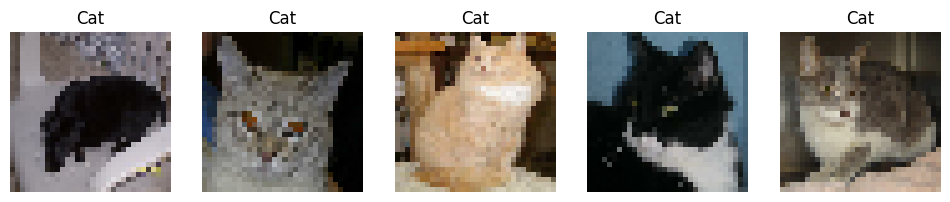

In [1]:
# Task 3: Cat vs Dog Image Classification Using SVM


# Step 1: Download Dataset
# Microsoft Kaggle Cats vs Dogs dataset (~787 MB)
!wget -O kagglecatsanddogs_5340.zip "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"

# Extract dataset
import zipfile, os
with zipfile.ZipFile('kagglecatsanddogs_5340.zip', 'r') as zip_ref:
    zip_ref.extractall('cats_and_dogs')

# Step 2: Import Required Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

# Step 3: Define Parameters
IMG_SIZE = 32               # Resize images for faster processing
MAX_IMAGES_PER_CLASS = 1000 # Limit images per class for fast training
PCA_COMPONENTS = 100        # Reduce dimensionality for SVM

# Step 4: Safe Image Loading Function
def load_images(folder, label, max_images=1000):
    """
    Loads images from a folder, resizes them, normalizes pixel values,
    and skips corrupted images.
    """
    images, labels = [], []
    count = 0
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        try:
            img = tf.io.read_file(path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0  # Normalize pixels to [0,1]
            images.append(img.numpy())
            labels.append(label)
            count += 1
            if count >= max_images:
                break
        except:
            continue
    return images, labels

# Step 5: Load Cat and Dog Images
cat_images, cat_labels = load_images('cats_and_dogs/PetImages/Cat', 0, MAX_IMAGES_PER_CLASS)
dog_images, dog_labels = load_images('cats_and_dogs/PetImages/Dog', 1, MAX_IMAGES_PER_CLASS)

# Step 6: Combine and Shuffle Dataset
images = np.array(cat_images + dog_images)
labels = np.array(cat_labels + dog_labels)

# Shuffle the dataset
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Step 7: Train/Test Split (80/20)
split = int(0.8 * len(images))
X_train, X_test = images[:split], images[split:]
y_train, y_test = labels[:split], labels[split:]

# Step 8: Flatten Images for SVM Input
X_train_np = X_train.reshape(X_train.shape[0], -1)
X_test_np = X_test.reshape(X_test.shape[0], -1)

# Step 9: Standardize Features
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

# Step 10: Apply PCA for Dimensionality Reduction
pca = PCA(n_components=PCA_COMPONENTS)
X_train_pca = pca.fit_transform(X_train_np)
X_test_pca = pca.transform(X_test_np)

# Step 11: Train SVM Classifier
clf = svm.SVC(kernel='linear')
clf.fit(X_train_pca, y_train)

# Step 12: Predict on Test Set
y_pred = clf.predict(X_test_pca)

# Step 13: Evaluate Performance
print("===== Classification Report =====\n")
print(classification_report(y_test, y_pred))
print("===== Accuracy =====")
print(accuracy_score(y_test, y_pred))

# Step 14: Visualize Sample Predictions
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[i])
    plt.title('Dog' if y_pred[i] == 1 else 'Cat')
    plt.axis('off')
plt.show()
